In [1]:
'''
Create a SLP project using labeled frames from from Label3D - posture net model
----------------------------------------------------
Takes labeled data from Label3D and reformats into 2D labels and frames.

Currently crops around the bird by finding the center of the labeled body points,
rather than using the comNet prediction as in SC's CreateDataset function.

Will need to use the comNet prediction for cropping unlabeled images for prediction.

Then, reformats the labels and images to create a SLP project.
'''
import numpy as np
import matplotlib.pyplot as plt
import csv
import mat73
import os 
import sys
sys.path.append("C:/Users/xl313/OneDrive/Documents/GitHub/poseTrackingXL/utils")
from slp_utils import crop_from_com
sys.path.append("../camera_calibration/")
import pySBA
from PIL import Image

In [2]:
''' ADJUST PARAMS AND PATHS AS NEEDED '''
''' cropping params '''
w3d = 65 # scaling factor # originally 0.25, but DA's coordinate system is 400x larger. the bigger the number, the less zoomed in
crop_size = (450, 450) # pixels - adjust later to (320,320)

In [3]:
''' set paths [should load only one session each time] '''
proj_date = "120324"
bird = 'SLV123'
session_date = '110824_noephys'

# load in Label3D training data
training_dir = 'Z:/Sherry/poseTrackingXL/training_files/LP_data/'
training_files = []
for f in os.listdir(training_dir):
    if (bird in f) and ('LP_ctx' in f) and (session_date in f) and ('start' in f) and ('end' in f) and ('unseen' in f):
        training_files.append(f)
training_files

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Z:/Sherry/poseTrackingXL/training_files/LP_data/'

In [4]:
# Load skeleton 
skeleton_file = 'C:/Users/xl313/OneDrive/Documents/GitHub/poseTrackingXL/postureNet/posture_skeleton_IL.csv'

# to open skeleton file and extract the name of all body parts in order
with open(skeleton_file, mode='r') as file:
    reader = csv.reader(file)
    header = next(reader)
    nodes = []
    for row in reader:
        nodes.append(row[0]) 
print(nodes)

['topBeak', 'botBeak', 'topHead', 'backHead', 'centerBack', 'baseTail', 'tipTail', 'leftEye', 'leftWing', 'leftAnkle', 'leftFoot', 'rightEye', 'rightWing', 'rightAnkle', 'rightFoot']


In [5]:
''' Functions '''
def formatData(data3D):
    '''
    Input: Label3D triangulated 3D points
    return: 3D points, attached with nFrames, average body parts  
    '''
    nFrames = data3D.shape[0]
    nParts = data3D.shape[1]//3
    data3D = np.reshape(data3D, (nFrames, nParts, 3)) # reshape the data 
    return (data3D, nFrames, nParts)

In [6]:
def avgBody(pt3d, body_idx=np.asarray([4, 5, 8, 12])): # Note: unlike in comNet, this only returns one rough centroid point 
    '''
    given a set of 3d points (shape (n_frames, n_parts, 3))
    averages across the body parts to get the rough centroid, which is one point
    
    default body_idx = [4, 5, 8, 12]
    - center back, base tail, left wing, right wing
    '''
    return np.mean(pt3d[:, body_idx], axis=1) 

In [7]:
def projectData(matfile):
    '''
    takes in a matfile from Label3D which contains
    - camera params
    - 3D point locations
    reshapes 3D data to (n_frames, n_nodes, 3)
    finds the scale to crop each frame around the bird
    reprojects onto each camera view to get an array of shape (n_frames, n_cams, n_nodes, 2) 
    '''
    camParams = pySBA.convertParams(matfile['camParams'])
    pt3d, nFrames, nParts = formatData(matfile['Triangulated3DPoints']) # use to be data_3D. 
    
    sba = pySBA.PySBA(camParams, np.NaN, np.NaN, np.NaN, np.NaN)
    nCams = camParams.shape[0]
    allCamScales = np.full((nFrames,nCams), np.NaN)
    allLabels = np.full((nFrames, nCams, nParts, 2), np.NaN)
    allCentroids = np.full((nFrames, nCams, 2), np.NaN)
    
    for nCam in range(nCams):
        # get the scales for this camera
        rot_vec = camParams[nCam][:3].reshape((1, 3))
        trans_vec = camParams[nCam][3:6]    
        focal_l = camParams[nCam][6]
        pt3d_centroid = np.mean(pt3d, axis=1) # average over all parts
        pt3d_centroid = sba.rotate(pt3d_centroid, np.tile(rot_vec, (nFrames, 1))) # rotate to camera coordinates
        camDist = pt3d_centroid[:, 2] + trans_vec[2] # get z-axis distance ie along optical axis
        camScale = focal_l / camDist # convert to focal length divided by distance
        allCamScales[:, nCam] = camScale
        
        # get the labels
        for nPart in range(nParts):
            allLabels[:, nCam, nPart, :] = sba.project(pt3d[:, nPart], np.tile(camParams[nCam], (nFrames,1)))
        
        # get the body centroids
        body_ctr = avgBody(pt3d)
        allCentroids[:, nCam, :] = sba.project(body_ctr, np.tile(camParams[nCam], (nFrames,1)))

    return allLabels, allCamScales, allCentroids

file_path

In [8]:
''' Load in all variables, Reformat 3D points from Label3D into an array of 2D points '''
# get the 2D points and frames for each Label3D file
# also get the body centroids and camera scales
all_labels = [] # (n_frames, n_cams, n_nodes, 2)
#all_label_frames = []
all_both_frames = [] # [LP]
all_idx = [] # [LP]
all_scales = [] # (n_frames, n_cams)
all_centroids = [] # (n_frames, n_cams, 2)

for fn in training_files:
    print(fn)
    file_path = f"{training_dir}{fn}"
    matfile = mat73.loadmat(file_path)
    labels, scales, centroids = projectData(matfile)
    #label_frame = []
    #for data in matfile['label_frames']: # read in label_frames 
     #   label_frame.append(data[0])
        
    both_frame = []
    for i in matfile['videos']: # read in both label and unlabel frames [LP]
        both_frame.append(i[0])
    idx = matfile['frame_idx']
    all_labels.append(labels)
    #all_label_frames.append(label_frame)
    all_both_frames.append(both_frame)  #[LP]
    all_idx.append(idx)
    all_scales.append(scales)
    all_centroids.append(centroids)
    
# reformat to get rid of the redundant 1st dimension 
all_labels = np.concatenate(all_labels, axis=0)
all_scales = np.concatenate(all_scales, axis=0)
all_centroids = np.concatenate(all_centroids, axis=0) 
all_idx = np.concatenate(all_idx, axis=0)

SLV123_110824_noephys_24_start32500_end33500_LP_ctx_unseen_inference_frames.mat


KeyError: 'Triangulated3DPoints'

In [23]:
# clean up label images and both images 
n_cams = all_labels.shape[1]
all_cams = []
both_frames = []
for c in range(n_cams):
    #label_image = np.concatenate([i[c] for i in all_label_frames], axis=3)
    both_image = np.concatenate([j[c] for j in all_both_frames], axis=3)
    all_cams.append(np.squeeze(label_image))
    both_frames.append(np.squeeze(both_image))
#del all_label_frames
#del all_both_frames

In [24]:
''' [both label and unlabel frames] concatenate across camera views, crop and resize frames '''
label_data = [] # shape (total_frames, n_nodes, 2)
# label_image_data = [] # shape (total_frames, ds_h, ds_w, RGB) from (ds_h,ds_w,RGB,total_frames)
both_image_data = []
# to get cropped images
for n_cam in range(n_cams):
    this_both_image_data = []
    this_label_data = []
    images = np.transpose(both_frames[n_cam], axes=[3,0,1,2]) 
    labels = all_labels[:, n_cam]
    labels = np.repeat(labels, repeats=5, axis=0)
    scales = all_scales[:, n_cam]
    scales = np.repeat(scales, repeats=5, axis=0)
    centroids = all_centroids[:, n_cam]
    centroids = np.repeat(centroids, repeats=5, axis=0)
    n_frames = labels.shape[0]
    for f in range(n_frames): 
        if np.isfinite(labels[f].sum()):
            half_width = np.round(w3d * scales[f])
            both_crop_img, both_min_ind, both_crop_scale = crop_from_com(images[f], 
                                                            centroids[f],
                                                            half_width,
                                                            crop_size)
            both_crop_ann = (labels[f] - both_min_ind) * both_crop_scale
        this_both_image_data.append(both_crop_img)
        this_label_data.append(both_crop_ann)
    label_data.append(this_label_data) 
    both_image_data.append(this_both_image_data) 

both_image_data = np.array(both_image_data)

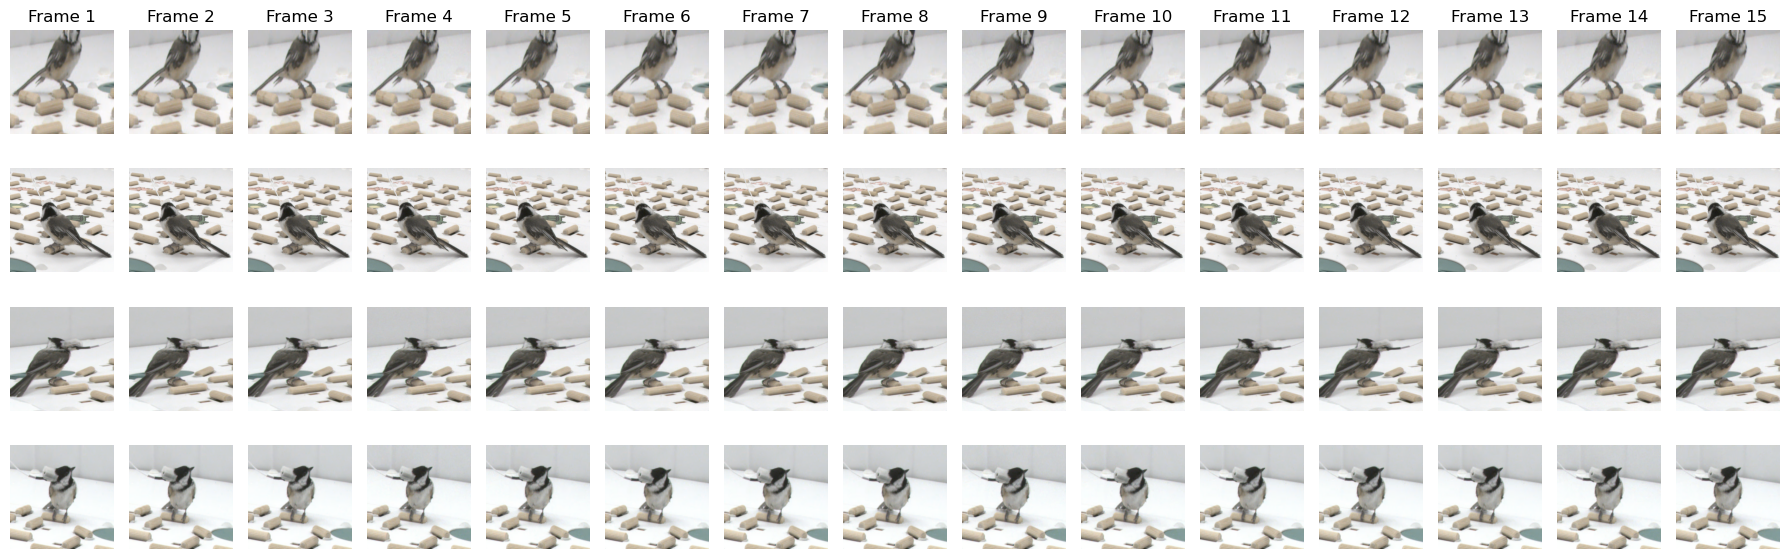

check no repeat: unique: 245 ,total: 245


In [25]:
selected_frames = np.array(both_image_data)  # Shape will be (2, 6, 500, 500, 3)

# Set up the plot with 2 rows and 6 columns
fig, axes = plt.subplots(4, 15, figsize=(18, 6))

# Loop over the first 2 cameras and first 6 frames for each
for cam_idx in range(4):
    for frame_idx in range(15):
        axes[cam_idx, frame_idx].imshow(selected_frames[cam_idx, frame_idx])
        axes[cam_idx, frame_idx].axis('off')  # Hide the axes for a cleaner look
        if cam_idx == 0:
            axes[cam_idx, frame_idx].set_title(f"Frame {frame_idx+1}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
print('check no repeat: unique:',len(np.unique(all_idx)),',total:',len(all_idx))

In [26]:
# Create session folders 
output_dir = os.path.join(r'Z:\Sherry\poseTrackingXL\training_files\LP_data\all')
os.makedirs(output_dir, exist_ok = True)

for cam_idx in range(both_image_data.shape[0]):
    # Create camera folders
    cam_folder = os.path.join(output_dir, 'labeled-data', f'{bird}_{session_date}_cam{cam_idx+1}')
    os.makedirs(cam_folder, exist_ok=True)
    vid_folder = os.path.join(output_dir, 'videos')
    os.makedirs(vid_folder, exist_ok=True)

    for frame_idx in range(both_image_data.shape[1]): # Generate image filenames first and then save the images to the corresponding filenames
        # Generate the image filename
        image_filename = f"img{int(all_idx[frame_idx]):007}.png" # 6 digits for AMB, 7 digits for SLV
        image_path = os.path.join(cam_folder, image_filename)
        # Save the image
        image_array = both_image_data[cam_idx, frame_idx]
        image = Image.fromarray(image_array)
        image.save(image_path)
        print(f"Saved {image_path}")
    

Saved Z:\Sherry\poseTrackingXL\training_files\LP_data\all\labeled-data\SLV123_110824_wEphys_cam1\img0005998.png
Saved Z:\Sherry\poseTrackingXL\training_files\LP_data\all\labeled-data\SLV123_110824_wEphys_cam1\img0005999.png
Saved Z:\Sherry\poseTrackingXL\training_files\LP_data\all\labeled-data\SLV123_110824_wEphys_cam1\img0006000.png
Saved Z:\Sherry\poseTrackingXL\training_files\LP_data\all\labeled-data\SLV123_110824_wEphys_cam1\img0006001.png
Saved Z:\Sherry\poseTrackingXL\training_files\LP_data\all\labeled-data\SLV123_110824_wEphys_cam1\img0006002.png
Saved Z:\Sherry\poseTrackingXL\training_files\LP_data\all\labeled-data\SLV123_110824_wEphys_cam1\img0011998.png
Saved Z:\Sherry\poseTrackingXL\training_files\LP_data\all\labeled-data\SLV123_110824_wEphys_cam1\img0011999.png
Saved Z:\Sherry\poseTrackingXL\training_files\LP_data\all\labeled-data\SLV123_110824_wEphys_cam1\img0012000.png
Saved Z:\Sherry\poseTrackingXL\training_files\LP_data\all\labeled-data\SLV123_110824_wEphys_cam1\img0012